# PyTorch🔥RNN - Predict Family Name Origins with LSTM Model (Variable Batch Length Approach)

Subject: Predicting the Language Origin of family names with an LSTM Model.

Data: Family Names in 18 Languages (from pytorch tutorial)

Procedure:

- Using string.ascii_letters list as a simple vocabulary
- Tokenizing characters in the family names
- Tensorizing train and target, with targets being the 18 languages
- Creating a torch.utils.data.TensorDataset and torch.utils.data.DataLoader
- We're training with batches. As all names need to have the same length in tensors, we apply a <b>variable batch length approach</b>: The training data is grouped into batches of the same name lenghts. Cf. other Notebook where a padding approach (with worse results) is applied.
- Creating torch.nn.module model with torch.nn.Linear, and torch.nn.LogSoftmax
- Training with torch.nn.CrossEntropyLoss, torch.optim.Adam, and hidden state tensors for storing the state in between a sequence
- Visualization of losses with pyplot
- Evaluation by classifying arbitrary input family names
- Quite encouraging results

Others:
- CUDA support
- working on Colab with Google Drive for loading data

Sources used:
- https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html  (includes dataset)

In [1]:
import torch
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Running on {DEVICE}')

if IN_COLAB := 'google.colab' in str(get_ipython()):
  from google.colab import drive
  drive.mount('/content/drive')
  BASE_PATH = './drive/MyDrive/Colab/'
  !pip install torchviz

else:
  BASE_PATH = '../'

Running on cuda
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from io import open
import glob
import os
import unicodedata
import string
import time
import math
import random
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from tqdm.auto import tqdm

## Data Preparation

In [3]:
BATCH_SIZE = 64

### Reading Files

In [4]:
# Some helper functions

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
print(f'All {n_letters} letters: {all_letters}')

def findFiles(path):
    return glob.glob(path)

# print(findFiles('data/names/*.txt'))

# Turn a Unicode string to plain ASCII
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(f'Ślusàrski -> {unicodeToAscii("Ślusàrski")}')

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

All 57 letters: abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'
Ślusàrski -> Slusarski


In [5]:
# list of all languages we have a .txt file for
all_categories = []

# map from language to list of all names
category_lines = {}

for filename in findFiles(BASE_PATH + 'data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

# print some example names for 'Italian'
print(category_lines['Italian'][400:415])

['Mantovani', 'Marchegiano', 'Marchesi', 'Marchetti', 'Marchioni', 'Marconi', 'Mari', 'Maria', 'Mariani', 'Marino', 'Marmo', 'Martelli', 'Martinelli', 'Masi', 'Masin']


### Convert Names to Tensors
To represent a single letter, we use a “one-hot vector” of size <1 x n_letters>.

To make a word we join a bunch of those into a 2D matrix <line_length x 1 x n_letters>.

In [6]:
# get letter index, e.g. "a" -> 0
def letterToIndex(letter: str) -> int:
    return all_letters.find(letter)

# turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = True
    return tensor

print(f"'J' -> {letterToTensor('J')}")  # [1, 57]

# print(f"'Jones' -> {lineToTensor('Jones')}")  # [5, 1, 57] torch.float32

'J' -> tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])


### Create a TensorDataset

In [7]:
all_names = [name for names in category_lines.values() for name in names]
max_name_length = max(len(name) for name in all_names)
print(f'Maximum name length: {max_name_length}')

n_names = len(all_names)
print(f'Total number of names: {n_names}')

# we will need a list with the corresponding language with same size as all_names
n_languages = len(category_lines)
print(f'Total number of languages: {n_languages}')

all_names_languages = [language for language, names in category_lines.items() for name in names]
print(f'Total number of language targets: {len(all_names_languages)}')

Maximum name length: 19
Total number of names: 20074
Total number of languages: 18
Total number of language targets: 20074


We don't need to one-hot-encode the labels, the loss function requires a 1-d tensor (2-d with batch)

In [8]:
names_tensor = torch.zeros(n_names, max_name_length, len(all_letters),
                           dtype=torch.torch.float32)  # [{n_names}, {max_name_length}, {n_letters}], e.g.  [20074, 19, 57]

targets_tensor = torch.zeros(n_names,
                             dtype=torch.int64)  # [20074]
#targets_tensor = torch.zeros(n_names, n_languages,   # --> if one-hot-encoded targets were required
#                             dtype=torch.int64)  # [{n_names}, {n_languages}] e.g. [20074, 18]

def get_tensor_for_name(name: str) -> torch.Tensor:
    name_tensor = torch.zeros(max_name_length, len(all_letters),
                              dtype=torch.torch.float32)  # 19, 57
    for letter_index, letter in enumerate(name):
        name_tensor[letter_index][letterToIndex(letter)] = 1
    return name_tensor

def get_name_for_tensor(name_tensor: torch.Tensor) -> str:  # name_tensor: [19, 57]
    name = ''
    for i, letter_tensor in enumerate(name_tensor):
        letter_index_tensor = letter_tensor.nonzero()  # no argmax() for boolean tensors
        if any(letter_index_tensor):
            letter_index = letter_index_tensor.item()
            name += all_letters[letter_index]
    return name

for name_index, name in enumerate(all_names):
    names_tensor[name_index] = get_tensor_for_name(name)

    language_of_name = all_names_languages[name_index]
    language_index = all_categories.index(language_of_name)
    targets_tensor[name_index] = language_index  # without one-hot-encoding
    #targets_tensor[name_index, language_index] = 1

In [9]:
assert names_tensor.shape[0] == targets_tensor.shape[0]
dataset = TensorDataset(names_tensor.to(DEVICE), targets_tensor.to(DEVICE))

### Create the DataLoader

We will return only batches of same size. Therefore, we don't need to add padding.

In [10]:
def bucketize_batches(names: list[str]):
    # for each name, we collect the length
    name_lengths = [len(name) for name in names]

    # to avoid padding, we collect each group of names with the same length into a bucket
    buckets = {}
    for index, length in enumerate(name_lengths):
        if length not in buckets:
            buckets[length] = []
        buckets[length].append(index)

    # the order is not random, so shuffle the indices within each bucket
    for length in buckets:
        random.shuffle(buckets[length])

    # as some buckets are too large, we split them into smaller buckets of max size BATCH_SIZE
    batches_bucket = []
    for length in buckets:
        indices = buckets[length]
        if len(indices) <= BATCH_SIZE:
            batches_bucket.append(indices)
        else:
            # n_chunks = math.ceil(len(indices) / BATCH_SIZE)
            for i in range(0, len(indices), BATCH_SIZE):
                batches_bucket.append(indices[i:i + BATCH_SIZE])

    # shuffle the order of the batches
    random.shuffle(batches_bucket)

    print(f"Number of batches: {len(batches_bucket)}")
    print(f"Max batch size: {max(len(batch) for batch in batches_bucket)}")
    print(f"Min batch size: {min(len(batch) for batch in batches_bucket)}")

    return batches_bucket


In [11]:
class RandomBucketSampler(torch.utils.data.sampler.Sampler):

    def __init__(self):
        self.batches_bucket = bucketize_batches(all_names)

    def __iter__(self):
        a = 1
        for batch in self.batches_bucket:
            yield batch
        b = 1

    def __len__(self):
        return len(self.batches_bucket)

In [12]:
# in the DataLoader, we will manually return a random batch of indices in the batches bucket
train_dataloader = DataLoader(dataset=dataset,  # list(train_iter),
                              # batch_size=8,
                              # shuffle=True,
                              # collate_fn=collate_batch,
                              batch_sampler=RandomBucketSampler(),
                              )

Number of batches: 324
Max batch size: 64
Min batch size: 1


## Model

In [13]:
HIDDEN_SIZE = 128
N_HIDDEN_LAYERS = 1

In [14]:
class LSTM(nn.Module):

    def __init__(self,
                 num_classes: int,  # number of languages, i.e. 18
                 input_size: int, # number of characters, i.e. 57
                 hidden_size: int,  # size of recurrent layer(s) HIDDEN_SIZE, e.g. 128
                 num_layers: int  # number of recurrent layers
                ):
        super(LSTM, self).__init__()

        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout = nn.Dropout(p=0.2)

        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True,
                            dropout = 0.25)

        self.fc = nn.Linear(in_features=hidden_size,
                            out_features=num_classes)

    def forward(self,
                input: torch.Tensor) -> torch.Tensor:  # [64, 128]
        h_0 = torch.zeros(
            self.num_layers, input.size(0), self.hidden_size).type(torch.float32).to(DEVICE)  # [1, 64, 128]

        c_0 = torch.zeros(
            self.num_layers, input.size(0), self.hidden_size).type(torch.float32).to(DEVICE)  # [1, 64, 128]

        # Propagate input through LSTM
        lstm_output, (_h_n, _c_n) = self.lstm(
            input=input,  # features of the input sequence
            hx=(h_0,  # initial hidden state for each element in the input sequence
                c_0))  # initial cell state for each element in the input sequence
        # --> lstm_output: output features (h_t) from the last layer of the LSTM, for each t
        #                  --> [batch_size, seq_len, hidden_size], i.e. [64, 19, 128]
        # --> _h_n: final (t = seq_len) hidden state for each element in the sequence
        #                  --> [num_layers, batch_size, hidden_size], i.e. [1, 64, 128]
        # --> _c_n: final (t = seq_len) cell state for each element in the sequence
        #                  --> [num_layers, batch_size, hidden_size], i.e. [1, 64, 128]

        fc_output = self.fc(lstm_output)  # same as self.fc(lstm_output[:, -1, :]) # [64, 18]
        # --> fc_output: [batch_size, seq_len, num_classes], i.e. [64, 19, 18]
        # h_out = h_n.view(-1, self.hidden_size)
        # out = self.fc(h_out)
        # out = self.dropout(out)

        final_output = self.dropout(fc_output)  # [64, 19, 18]

        return final_output


To run a step of this network we need to pass an input (in our case, the Tensor for the current letter) and a previous hidden state (which we initialize as zeros at first). We’ll get back the output (probability of each language) and a next hidden state (which we keep for the next step).

In [15]:
def predict_example(name: str, model):
    model.eval()

    input = get_tensor_for_name(name)  # [19, 57]
    input_as_batch = torch.unsqueeze(input, dim=0).to(DEVICE)  # [1, 19, 57]

    with torch.no_grad():
        predicted_logits = model(input_as_batch)  # [1, 19, 18]

    predicted_language = all_categories[predicted_logits[0][-1].argmax().item()]

    for i, letter in enumerate(name):
        predicted_language = all_categories[predicted_logits[0][i].argmax().item()]
        print(f"Guess after {letter}: {predicted_language}")

    predicted_language = all_categories[predicted_logits[0][-1].argmax().item()]
    print(f"\nGuess after max letters: {predicted_language}")

In [16]:
# Let's try for 'Jones' with an untrained Model
model = LSTM(num_classes=len(all_categories),
             input_size=n_letters,
             hidden_size=HIDDEN_SIZE,
             num_layers=N_HIDDEN_LAYERS).to(DEVICE)

predict_example(name='Jones', model=model)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Guess after J: Czech
Guess after o: Czech
Guess after n: Czech
Guess after e: Czech
Guess after s: Scottish

Guess after max letters: Czech


## Training

In [17]:
N_EPOCHS = 3

# If you set this too high, it might explode.
# If too low, it might not learn
LEARNING_RATE = 0.001

PRINT_EVERY_N_STEPS = 300
PLOT_EVERY_N_STEPS = 100

### Helper Functions

In [18]:
# Tracking Time
def timeSince(since):
    now = time.time()
    seconds = now - since
    minutes = math.floor(seconds / 60)
    seconds -= minutes * 60
    return f'{minutes} min. {round(seconds)} sec.'

In [19]:
def get_name_length(x: torch.Tensor) -> int:
    for i in range(len(x[0])):
        if not any(x[0][i]):
            return i
    return len(x[0])

### Train

In [20]:
# rnn = RNN(input_size=n_letters, hidden_size=HIDDEN_SIZE, output_size=len(all_categories))
model = LSTM(num_classes=len(all_categories),
             input_size=n_letters,
             hidden_size=HIDDEN_SIZE,
             num_layers=N_HIDDEN_LAYERS).to(DEVICE)

# For the loss function nn.NLLLoss is appropriate,
# since the last layer of the RNN is nn.LogSoftmax.
# criterion = nn.NLLLoss()
criterion = nn.CrossEntropyLoss()


#optimizer = torch.optim.RMSprop(model.parameters(),
#                                lr = LEARNING_RATE)
optimizer = torch.optim.Adam(model.parameters(),
                             lr=LEARNING_RATE)


Each loop of training will:
1. Create input and target tensors
2. Create a zeroed initial hidden state
3. Read each letter in and
4. Keep hidden state for next letter
5. Compare final output to target
6. Back-propagate
7. Return the output and loss

In [21]:
N_TOTAL_STEPS = len(dataset) * N_EPOCHS

start = time.time()

# Keep track of losses for printing and plotting
all_losses = []
current_loss = 0

model.train()
current_step = 0
for epoch in range(N_EPOCHS):

    for x_train, y_train in tqdm(train_dataloader):  # x_train: [~64, 19, 57]  y_train: [~64]
        current_step += 1

        # reduce tensor size to the last letter
        name_length_current_batch = get_name_length(x=x_train)
        x_train = x_train[:, :name_length_current_batch, :]  # [64, 19, 57] --> [64, e.g. 5, 57]

        model.zero_grad()
        pred_logits_train = model(x_train)  # [batch_size, seq_len, num_classes], i.e. [64, 19, 18]
        pred_logits_train_last_seq = pred_logits_train[:, -1, :]  # [64, 18]

        loss = criterion(pred_logits_train_last_seq, y_train)  # [], e.g. tensor(0.0006, grad_fn=<NllLossBackward0>)
        loss.backward()
        optimizer.step()

        current_loss += loss.item()
        # all_losses.append(loss.item())

        # Print ``iter`` number, loss, name and guess
        if current_step % PRINT_EVERY_N_STEPS == 0:
            first_output_in_batch = pred_logits_train_last_seq[0]  # [18]
            predicted_language = all_categories[first_output_in_batch.argmax()]
            target_language = all_categories[y_train[0].item()]
            # guess, guess_i = get_category_from_output(output)
            correct = '✓' if predicted_language == target_language else '✗ (%s)' % target_language
            line = get_name_for_tensor(x_train[0])
            print(
                f'{current_step :d} {(current_step / N_TOTAL_STEPS * 100) :.2f} ({timeSince(start) :s}) {loss :.4f} {line :s} / {predicted_language :s} {correct :s}')

        # Add current loss avg to list of losses
        if current_step % PLOT_EVERY_N_STEPS == 0:
            all_losses.append(current_loss / PLOT_EVERY_N_STEPS)
            current_loss = 0


  0%|          | 0/324 [00:00<?, ?it/s]

300 0.07 (0 min. 3 sec.) 1.6789 Mhonov / Russian ✓


  0%|          | 0/324 [00:00<?, ?it/s]

600 0.15 (0 min. 6 sec.) 0.9396 Ksmtsu / Japanese ✓


  0%|          | 0/324 [00:00<?, ?it/s]

900 0.22 (0 min. 8 sec.) 0.8882 Wclusk / Italian ✗ (Czech)


  0%|          | 0/324 [00:00<?, ?it/s]

1200 0.30 (0 min. 9 sec.) 1.6910 Abno / Russian ✗ (Spanish)


  0%|          | 0/324 [00:00<?, ?it/s]

1500 0.37 (0 min. 11 sec.) 0.6057 Shhnzrynts / Russian ✓


  0%|          | 0/324 [00:00<?, ?it/s]

1800 0.45 (0 min. 13 sec.) 2.2596 Lu / Chinese ✓


  0%|          | 0/324 [00:00<?, ?it/s]

2100 0.52 (0 min. 14 sec.) 1.1309 Dovgn / Russian ✓


  0%|          | 0/324 [00:00<?, ?it/s]

2400 0.60 (0 min. 16 sec.) 0.8158 Abboud / Arabic ✓


  0%|          | 0/324 [00:00<?, ?it/s]

2700 0.67 (0 min. 18 sec.) 0.7077 Johnsen / English ✓


  0%|          | 0/324 [00:00<?, ?it/s]

3000 0.75 (0 min. 20 sec.) 1.0122 Fulker / Russian ✗ (English)


  0%|          | 0/324 [00:00<?, ?it/s]

3300 0.82 (0 min. 22 sec.) 0.7834 Shdsky / Russian ✓


  0%|          | 0/324 [00:00<?, ?it/s]

3600 0.90 (0 min. 24 sec.) 0.4006 Zilberschlg / German ✓


  0%|          | 0/324 [00:00<?, ?it/s]

3900 0.97 (0 min. 25 sec.) 0.6293 Glzty / Russian ✓
4200 1.05 (0 min. 27 sec.) 0.8977 Ykshin / Russian ✓


  0%|          | 0/324 [00:00<?, ?it/s]

4500 1.12 (0 min. 28 sec.) 0.5989 Achilles / Russian ✗ (German)


  0%|          | 0/324 [00:00<?, ?it/s]

4800 1.20 (0 min. 30 sec.) 0.5868 Djnkezov / Russian ✓


  0%|          | 0/324 [00:00<?, ?it/s]

5100 1.27 (0 min. 32 sec.) 0.4676 Theunissen / English ✗ (Dutch)


  0%|          | 0/324 [00:00<?, ?it/s]

5400 1.35 (0 min. 34 sec.) 0.4889 Okzwy / Russian ✗ (Japanese)


  0%|          | 0/324 [00:00<?, ?it/s]

5700 1.42 (0 min. 36 sec.) 0.9526 Currn / English ✗ (Irish)


  0%|          | 0/324 [00:00<?, ?it/s]

6000 1.49 (0 min. 37 sec.) 0.5092 Bkhmtoff / Russian ✓


  0%|          | 0/324 [00:00<?, ?it/s]

6300 1.57 (0 min. 39 sec.) 0.5240 Luspekev / Russian ✓


## Visualize

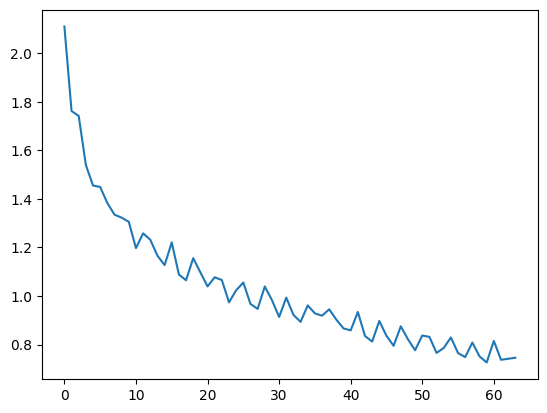

In [22]:
plt.figure()
plt.plot(all_losses)

## Let's show that it's really about the sequence

In [24]:
def predict_example(name: str, model):
    model.eval()

    input = get_tensor_for_name(name)  # [19, 57]
    input_as_batch = torch.unsqueeze(input, dim=0).to(DEVICE)  # [1, 19, 57]

    with torch.no_grad():
        predicted_logits = model(input_as_batch)  # [1, 19, 18]

    predicted_language = all_categories[predicted_logits[0][-1].argmax().item()]

    for i in range(len(name)):
        predicted_language = all_categories[predicted_logits[0][i].argmax().item()]
        print(f"Guess for {name[:i+1]}: {predicted_language}")

    predicted_language = all_categories[predicted_logits[0][-1].argmax().item()]
    print(f"\nGuess after max letters: {predicted_language}")

predict_example(name='Zhang', model=model)

Guess for Z: Chinese
Guess for Zh: Russian
Guess for Zha: Chinese
Guess for Zhan: Chinese
Guess for Zhang: Chinese

Guess after max letters: Russian
